<a href="https://colab.research.google.com/github/evan-carey/cst383-project/blob/main/predicting_the_next_big_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting The Next Big Game

### By Omar Spiller Hernandez, Scott Lam, Evan Carey, and David Gil

### 14 February 2024



# Dataset


The Steam games dataset is a collection of information of more than 97,000 games that are available on the steam platform. This dataset collects all data using the official Steam API and Steam spy which results in a snapshot of each game's attributes. This includes things such as names, release dates, financial metrics such as discounts as well as a look into user engagement. This is measured through how many users own the game, users currently engaged in playing the games and review statistics. There is also other data such as supported devices and operating systems, region and languages the game is available. With this much information it should be possible to run an analysis of a game's performance in the market.

https://www.kaggle.com/datasets/fronkongames/steam-games-dataset

# Prediction

**Background**

The video game market on Steam is competitive with countless titles released yearly on the platform. Developers and publishers could benefit from knowing what makes a game successful.We selected the STEAM games dataset for this project. The primary question or problem that we decided to solve with this dataset is "Which game features based on the data are correlated with better user ratings?" If we analyze the relationships between available pieces of data we can see which are measures of success that give higher user ratings. For a broader scope in our project we could ask ourselves if a predictive model can be created that will estimate the likelihood of a game achieving success on release, success based on ratings.

**What We Predict**

We predict when a game has a high meta critic score and good reviews its the next big game.

# Features

Using 'User score', 'Metacritic score', 'Positive', 'Negative', 'Recommendations', 'Reviews', 'About the game' and 'Estimated owners' we should be able to predict the next up and coming game on the market. While looking at reviews, overal scores, and number of sales of the games we'll discover the most top rated games on the market.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [3]:
# code in this cell from:
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

## Upload Dataset

Upload the "games.csv" file to your Jupyter Notebook project

In [4]:
# NOTE: I am using a local copy of the data because it's slow to download from GitHub
# If you want to use the data from GitHub, uncomment the line below and comment out the line after it

# df = pd.read_csv("https://github.com/evan-carey/cst383-project/raw/refs/heads/main/converted.csv")
df = pd.read_csv("converted.csv")

# drop columns that are not useful for analysis
df.drop(['Header image', 'Website', 'Support url', 'Support email', 'Metacritic url', 'Screenshots', 'Movies'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97410 entries, 0 to 97409
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       97410 non-null  int64  
 1   index                       97410 non-null  int64  
 2   Name                        97404 non-null  object 
 3   Release date                97410 non-null  object 
 4   Required age                97410 non-null  int64  
 5   Price                       97410 non-null  float64
 6   DLC count                   97410 non-null  int64  
 7   Detailed description        92562 non-null  object 
 8   About the game              92540 non-null  object 
 9   Short description           92631 non-null  object 
 10  Reviews                     10125 non-null  object 
 11  Windows                     97410 non-null  bool   
 12  Mac                         97410 non-null  bool   
 13  Linux                       974

In [6]:
df.describe()

,AppID,index,Required age,Price,DLC count,Metacritic score,Achievements,Recommendations,User score,Score rank,Positive,Negative,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Peak CCU
count,9.741000e+04,9.741000e+04,97410.000000,97410.000000,97410.000000,97410.000000,97410.000000,9.741000e+04,97410.000000,44.000000,9.741000e+04,97410.000000,97410.000000,97410.000000,97410.000000,97410.000000,9.741000e+04
mean,1.524636e+06,1.524636e+06,0.282497,7.086262,0.493081,2.959193,18.562622,6.905128e+02,0.034791,98.909091,8.489366e+02,141.065989,91.797937,9.621271,81.852459,10.340417,1.627283e+02
std,8.001310e+05,8.001310e+05,2.144294,12.387782,12.832834,14.545462,160.413540,1.681717e+04,1.674105,0.857747,2.287011e+04,4278.019743,1068.494928,177.190210,1412.496536,192.711603,7.687116e+03
min,1.000000e+01,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,8.477925e+05,8.477925e+05,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1.489990e+06,1.489990e+06,0.000000,4.190000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,99.000000,5.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,2.180648e+06,2.180648e+06,0.000000,9.990000,0.000000,0.000000,17.000000,0.000000e+00,0.000000,100.000000,3.500000e+01,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
max,3.199580e+06,3.199580e+06,21.000000,999.980000,2366.000000,97.000000,9821.000000,3.441592e+06,100.000000,100.000000,5.764420e+06,895978.000000,145727.000000,19159.000000,208473.000000,19159.000000,1.284268e+06


In [7]:
df['Estimated owners'].value_counts()

Estimated owners
0 - 20000                61433
0 - 0                    17263
20000 - 50000             8034
50000 - 100000            3978
100000 - 200000           2611
200000 - 500000           2169
500000 - 1000000           912
1000000 - 2000000          523
2000000 - 5000000          330
5000000 - 10000000          92
10000000 - 20000000         38
20000000 - 50000000         21
50000000 - 100000000         5
100000000 - 200000000        1
Name: count, dtype: int64

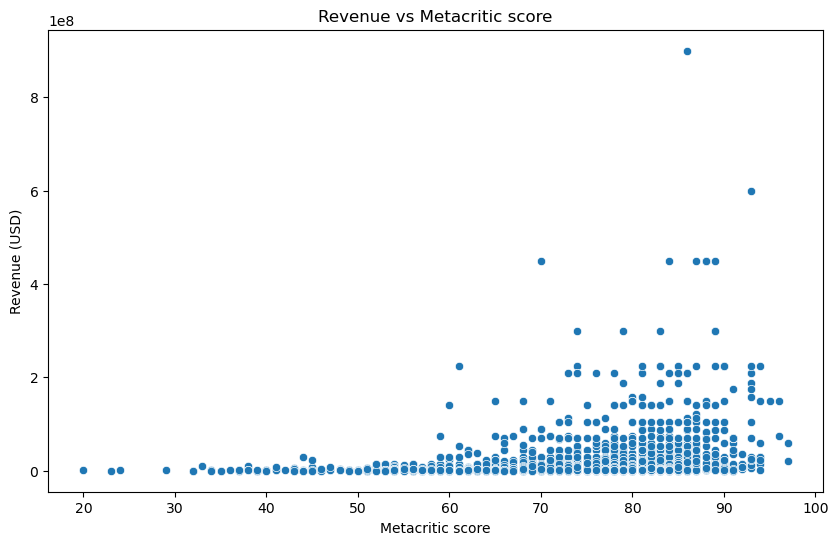

In [8]:
# looking at sales data

# remove rows with no sales data
df = df[df['Estimated owners'] != '0 - 0']
# remove rows with no price data (free games)
df = df[df['Price'] != 0.0]

# remove rows with no metacritic score
df = df[df['Metacritic score'] != 0]

# drop Dota 2 because it is an outlier
df = df[df['Estimated owners'] != '100000000 - 200000000']
# drop some other outliers (games with 20,000,000 - 50,000,000 owners)
df = df[df['Estimated owners'] != '20000000 - 50000000']
# drop the lowest revenue games (games with 0 - 20,000 owners)
df = df[df['Estimated owners'] != '0 - 20000']


# convert 'Estimated owners' to a float by taking the average of the range
df['estimated_num_owners'] = df['Estimated owners'].str.split(' - ').apply(lambda x: (float(x[0]) + float(x[1])) / 2)

# add a column for 'revenue', which is 'estimated_num_owners' * 'Price'
df['revenue'] = (df['estimated_num_owners'] * df['Price']).round()

# remove the outlier with the highest revenue
df = df[df['revenue'] != df['revenue'].max()]

# plot revenue vs metacritic score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Metacritic score', y='revenue')
plt.title('Revenue vs Metacritic score')
plt.ylabel('Revenue (USD)')
plt.show()


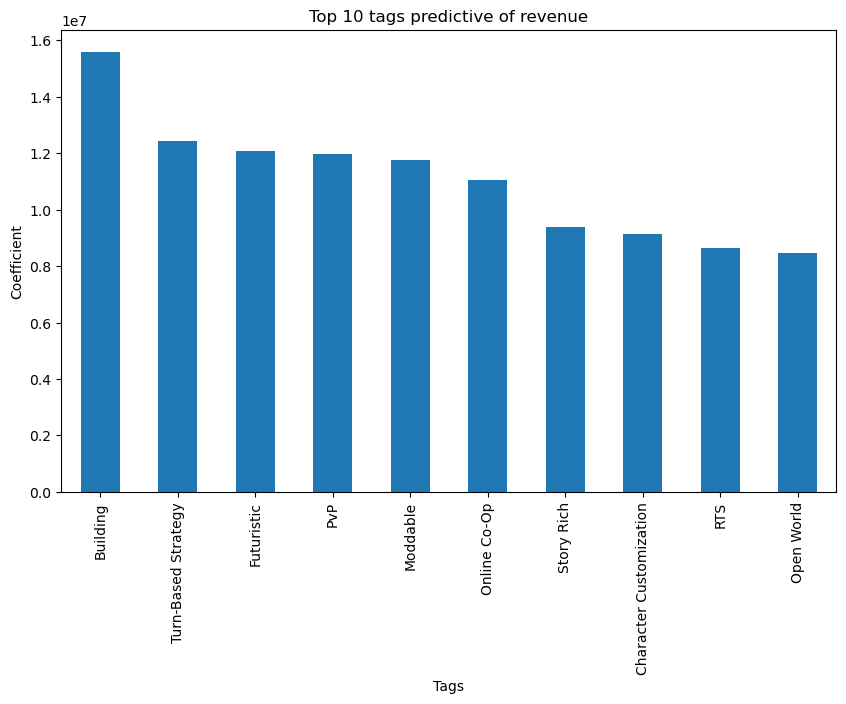

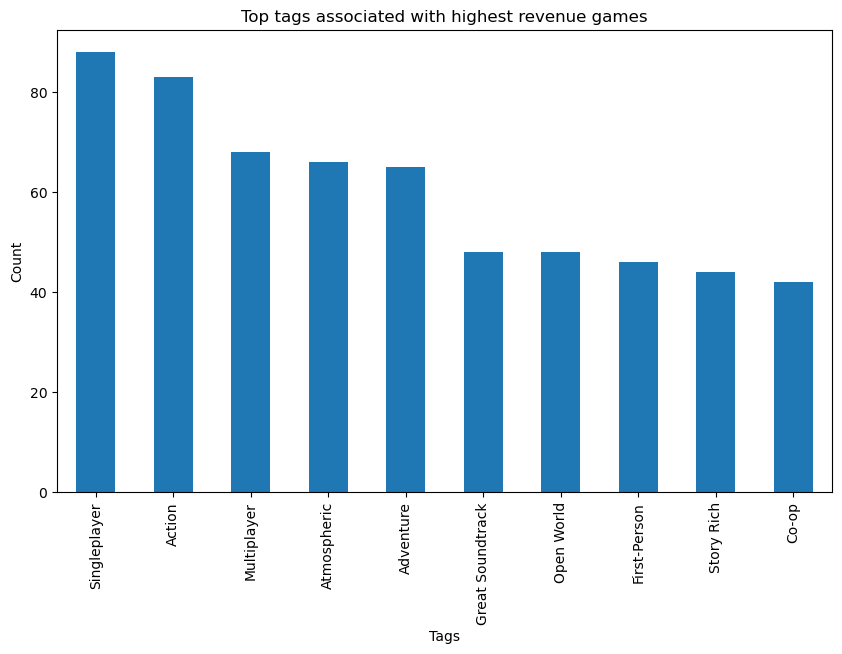

In [18]:
# let's look at Tags to see if we can find any patterns

# drop rows with no tags
df = df.dropna(subset=['Tags'])

# split the tags into a list of tags
df['tags_split'] = df['Tags'].str.split(',')

# get the value counts of all the tags
tag_counts = df['tags_split'].explode().value_counts()

# let's only keep the top 100 most common tags
top_tags = tag_counts.head(100).index.values
# create a new column 'tags_top' that only contains the top 100 tags
df['tags_top'] = df['tags_split'].apply(lambda x: [tag for tag in x if tag in top_tags])


# one-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['tags_top'])
# create a DataFrame from the one-hot encoded tags
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)
# concatenate the one-hot encoded tags with the original DataFrame
df_mlb = pd.concat([df, tags_df], axis=1)
# df_mlb.drop(['Tags', 'tags_split'], axis=1, inplace=True)

# use the one-hot encoded tags as features in a regression model to see which tags are most predictive of revenue
X = tags_df
y = df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# use a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# get the coefficients of the linear regression model
coefficients = pd.Series(lr.coef_, index=tags_df.columns)
# sort the coefficients
coefficients = coefficients.sort_values(ascending=False)
# plot the coefficients
plt.figure(figsize=(10, 6))
coefficients.head(10).plot(kind='bar')
plt.title('Top 10 tags predictive of revenue')
plt.xlabel('Tags')
plt.ylabel('Coefficient')
plt.show()

# let's find the tags associated with the highest revenue games
top_revenue_games = df_mlb.sort_values('revenue', ascending=False).head(100)
# get the value counts of the tags for the top revenue games
top_revenue_tags = top_revenue_games['tags_top'].explode().value_counts()
# plot the top tags associated with the highest revenue games
plt.figure(figsize=(10, 6))
top_revenue_tags.head(10).plot(kind='bar')
plt.title('Top tags associated with highest revenue games')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()



## Missing Data

In [10]:
print(df.isnull().sum())

AppID                            0
index                            0
Name                             0
Release date                     0
Required age                     0
Price                            0
DLC count                        0
Detailed description             4
About the game                   7
Short description                0
Reviews                       1442
Windows                          0
Mac                              0
Linux                            0
Metacritic score                 0
Achievements                     0
Recommendations                  0
Notes                         2849
Supported languages              0
Full audio languages          1298
Packages                         0
Developers                       0
Publishers                      19
Categories                       3
Genres                           5
User score                       0
Score rank                    3063
Positive                         0
Negative            

In [56]:
# We need to transform the 'Positive' and 'Negative' columns to be a fraction of the total reviews
# This will allow us to compare games with different numbers of reviews
df['positive_fraction'] = df['Positive'] / (df['Positive'] + df['Negative'])
df['negative_fraction'] = df['Negative'] / (df['Positive'] + df['Negative'])


Training set: (2143, 4), Test set: (919, 4)
Coefficients:
  Metacritic score: 672630.05
  positive_fraction: -229115.69
  negative_fraction: 229115.69
  Average playtime forever: 12847.42
RMSE: 36409382.40
R^2: 0.31


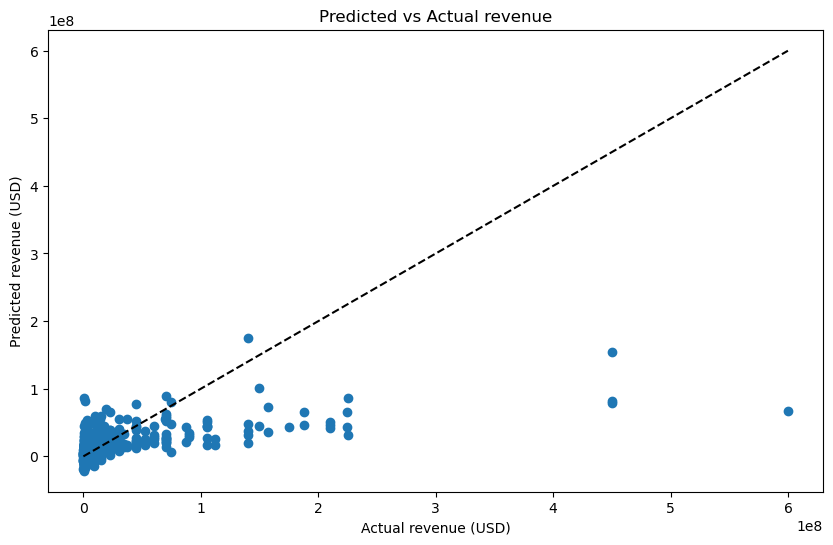

In [ ]:
predictors = ['Metacritic score', 'positive_fraction', 'negative_fraction', 'Average playtime forever']
target = 'revenue'

df = df.dropna(subset = predictors)
# drop rows where Metacritic score is 0
df = df[df['Metacritic score'] != 0]

df['About the game'] = df['About the game'].astype(str)
df['About the game'] = df['About the game'].apply(lambda x: len(x))

X = df[predictors]
y = df[target]

# Split into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# run the regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# print the intercept
print('Intercept:', reg.intercept_)

# print the coefficients
print('Coefficients:')
for i in range(len(predictors)):
    print(f'  {predictors[i]}: {reg.coef_[i]:.2f}')



y_pred = reg.predict(X_test)
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print('RMSE: {:.2f}'.format(rmse))
# print r^2 score
r2 = reg.score(X_test, y_test)
print('R^2: {:.2f}'.format(r2))

## plot the predicted vs actual revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], color='black', linestyle='--')
plt.xlabel('Actual revenue (USD)')
plt.ylabel('Predicted revenue (USD)')
plt.title('Predicted vs Actual revenue')
plt.show()

## Comparing Metacritic Score & Positive Reviews

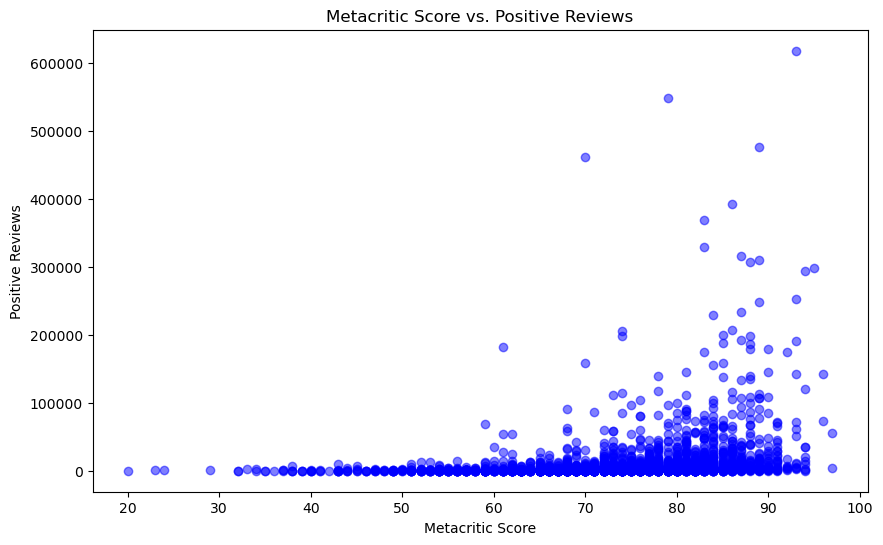

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Metacritic score'], df['Positive'], c = 'blue', alpha = 0.5)

plt.title('Metacritic Score vs. Positive Reviews')
plt.xlabel('Metacritic Score')
plt.ylabel('Positive Reviews')

plt.show()